# Comparing Firearm Mortality and State Gun Law Restrictions

The Centers for Disease Control and Prevention (CDC) publishes firearm mortality rates for each U.S. state, expressed per 100,000 persons. To quantify the relative strictness of firearm legislation, this analysis incorporates state-level grades from the World Population Review, which evaluates the comprehensiveness of gun control measures and assigns a letter grade ranging from **A**(strictest) to **F** (least strict). These grades are subsequently transformed into a five-point Likert scale spanning **Very Strong** to **Very Weak** to facilitate our analysis.

>The objective of this study is to examine the relationship between the strength of state firearm laws and firearm mortality rates, addressing the guiding question: **“Do stricter firearm control laws contribute to lower firearm mortality?”**

**Data Sources**

- [Centers for Disease Control and Prevention – Firearm Mortality](https://www.cdc.gov/nchs/state-stats/deaths/firearms.html?CDC_AAref_Val=https://www.cdc.gov/nchs/pressroom/sosmap/firearm_mortality/firearm.htm)
- [World Population Review – Strictest Gun Laws by State](https://worldpopulationreview.com/state-rankings/strictest-gun-laws-by-state)

## Obtain CDC data via API

We will obtain the data from the CDC that also contains homicide and suicide breakouts of the firearm death rate. 

In [11]:
import requests
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

BASE = "https://data.cdc.gov/resource/fpsi-y8tj.json"

def fetch_firearm_state(period="2023", intent="FA_Deaths"):
    params = {
        "$select": "name as state, geoid, intent, period, rate, count_sup, data_as_of",
        "$where": f"period='{period}' AND intent='{intent}'",
        "$order": "state",
        "$limit": 50000
    }
    r = requests.get(BASE, params=params, timeout=60)
    r.raise_for_status()
    df = pd.DataFrame(r.json())
    if not df.empty and "rate" in df.columns:
        df["rate"] = pd.to_numeric(df["rate"], errors="coerce")
    return df

# All firearm deaths by state for 2023
df_all = fetch_firearm_state(period="2023", intent="FA_Deaths")

# Obtain Homicide and Suicde Rates
df_homicide = fetch_firearm_state(period="2023", intent="FA_Homicide")
df_suicide = fetch_firearm_state(period="2023", intent="FA_Suicide")

# Combinne each query
combined = (
    df_all.merge(df_homicide[["state","rate"]].rename(columns={"rate":"fa_homicide_rate"}), on="state", how="left")
          .merge(df_suicide[["state","rate"]].rename(columns={"rate":"fa_suicide_rate"}), on="state", how="left")
)

combined.to_csv("firearm_mortality_by_state_2023.csv", index=False)

combined.head()


,state,geoid,intent,period,rate,count_sup,data_as_of,fa_homicide_rate,fa_suicide_rate
0,Alabama,01,FA_Deaths,2023,25.3,1292,2025-09-05T00:00:00.000,12.4,12.1
1,Alaska,02,FA_Deaths,2023,24.0,176,2025-09-05T00:00:00.000,6.4,16.4
2,Arizona,04,FA_Deaths,2023,19.1,1419,2025-09-05T00:00:00.000,5.5,12.8
3,Arkansas,05,FA_Deaths,2023,21.9,671,2025-09-05T00:00:00.000,8.6,12.8
4,California,06,FA_Deaths,2023,8.2,3209,2025-09-05T00:00:00.000,3.7,4.2


## Obtain Gun Laws Rating from World Population Review

The data was downloaded from the website as a CSV and will be joined with out primary CDC dataset.

In [12]:
df_laws = pd.read_csv("strictest-gun-laws-by-state-2025.csv")

# If you have different spellings, normalize IN PLACE without creating a key column
combined["state"] = combined["state"].str.strip().replace({"Washington, D.C.": "District of Columbia"})
df_laws["state"] = df_laws["state"].str.strip().replace({"Washington, D.C.": "District of Columbia"})

# Keep only the grade column from df_laws, then merge on 'state'
laws_keep = df_laws[["state", "StrictestGunLawsGiffordGrade_2024"]].drop_duplicates("state")

merged = combined.merge(laws_keep, on="state", how="left")

# Optional: see which states did not match
missing = sorted(set(merged["state"]) - set(laws_keep["state"]))
if missing:
    print("No grade found for:", missing)

merged.head()

No grade found for: ['District of Columbia']


,state,geoid,intent,period,rate,count_sup,data_as_of,fa_homicide_rate,fa_suicide_rate,StrictestGunLawsGiffordGrade_2024
0,Alabama,01,FA_Deaths,2023,25.3,1292,2025-09-05T00:00:00.000,12.4,12.1,F
1,Alaska,02,FA_Deaths,2023,24.0,176,2025-09-05T00:00:00.000,6.4,16.4,F
2,Arizona,04,FA_Deaths,2023,19.1,1419,2025-09-05T00:00:00.000,5.5,12.8,F
3,Arkansas,05,FA_Deaths,2023,21.9,671,2025-09-05T00:00:00.000,8.6,12.8,F
4,California,06,FA_Deaths,2023,8.2,3209,2025-09-05T00:00:00.000,3.7,4.2,A


## Map Gun Law Grade to Likert Scale

Essentially we will xtract a clean letter grade like A, A-, A+, B, B+, B-, ..., F to become a category of our 5-Point Likert Scale

In [13]:
g = (
    merged["StrictestGunLawsGiffordGrade_2024"]
      .astype(str).str.upper().str.strip()
      .str.extract(r'(A\+|A\-|A|B\+|B\-|B|C\+|C\-|C|D\+|D\-|D|F)')[0]
      .where(merged["StrictestGunLawsGiffordGrade_2024"].notna())
)

grade_to_likert = {
    "A+": "Very Strong", "A": "Very Strong", "A-": "Very Strong",
    "B+": "Strong", "B": "Strong", "B-": "Strong",
    "C+": "Neutral", "C": "Neutral", "C-": "Neutral",
    "D+": "Weak", "D": "Weak", "D-": "Weak",
    "F": "Very Weak",
}

merged["StrictestGunLawsGiffordGrade_2024"] = g.map(grade_to_likert)

likert_order = ["Very Weak", "Weak", "Neutral", "Strong", "Very Strong"]
cat = pd.CategoricalDtype(categories=likert_order, ordered=True)
merged["StrictestGunLawsGiffordGrade_2024"] = merged["StrictestGunLawsGiffordGrade_2024"].astype(cat)

unmapped = merged[merged["StrictestGunLawsGiffordGrade_2024"].isna()]
if not unmapped.empty:
    print("Unmapped grades:")
    print(unmapped[["state"]].assign(original=merged["StrictestGunLawsGiffordGrade_2024"]))

merged = merged.rename(columns={'StrictestGunLawsGiffordGrade_2024':'gun_laws'})

merged.head()

Unmapped grades:
                  state original
8  District of Columbia      NaN


,state,geoid,intent,period,rate,count_sup,data_as_of,fa_homicide_rate,fa_suicide_rate,gun_laws
0,Alabama,01,FA_Deaths,2023,25.3,1292,2025-09-05T00:00:00.000,12.4,12.1,Very Weak
1,Alaska,02,FA_Deaths,2023,24.0,176,2025-09-05T00:00:00.000,6.4,16.4,Very Weak
2,Arizona,04,FA_Deaths,2023,19.1,1419,2025-09-05T00:00:00.000,5.5,12.8,Very Weak
3,Arkansas,05,FA_Deaths,2023,21.9,671,2025-09-05T00:00:00.000,8.6,12.8,Very Weak
4,California,06,FA_Deaths,2023,8.2,3209,2025-09-05T00:00:00.000,3.7,4.2,Very Strong


## Export Data as CSV

In [14]:
merged.to_csv("gun_data.csv")

## Comparing Each State's Gun Laws and Corresponding Firearm Mortality Rate (Per 100,000 Persons)

This visualization was developed by adapting a matrix-style layout inspired by The New York Times, in which each state is represented by an equally sized cell. The grid is color-coded according to the relative strength of firearm legislation, enabling a comparative assessment across states. Each cell is labeled with the state abbreviation and its corresponding firearm mortality rate.
It was created using Plotly, marking my initial attempts of this library. With assistance from Google AI, an interactive heatmap was constructed featuring hover tooltips that reveal additional contextual information. These tooltips enable a more detailed exploration of the data, including subcategories such as homicide and suicide rates.

**Data Visulaization Ideas**

- [New York Times](https://archive.nytimes.com/www.nytimes.com/interactive/2013/06/26/us/scotus-gay-marriage.html)
- [Github](https://github.com/kristw/gridmap-layout-usa?tab=readme-ov-file)

When examining the map, it becomes evident that states with stricter gun laws are generally concentrated along the eastern and western coastlines. Overall, the firearm mortality rate for these states tends to range between 4 and 15 deaths per 100,000 persons. In contrast, many southern states exhibit more lenient firearm regulations and correspondingly higher death rates, typically between 15 and 28 per 100,000.
These patterns suggest that, in general, stronger gun laws are associated with lower firearm mortality. However, there are notable exceptions. For example, Texas (TX) reports a firearm death rate of approximately 15 per 100,000, which is substantially lower than that of several other southern states, such as Alabama (AL) reporting a firearm death rate of approximately 25 per 100,000.

In [15]:
import plotly.express as px

# state name to USPS code
name_to_code = {
    'Alabama':'AL','Alaska':'AK','Arizona':'AZ','Arkansas':'AR','California':'CA','Colorado':'CO',
    'Connecticut':'CT','Delaware':'DE','District of Columbia':'DC','Florida':'FL','Georgia':'GA',
    'Hawaii':'HI','Idaho':'ID','Illinois':'IL','Indiana':'IN','Iowa':'IA','Kansas':'KS','Kentucky':'KY',
    'Louisiana':'LA','Maine':'ME','Maryland':'MD','Massachusetts':'MA','Michigan':'MI','Minnesota':'MN',
    'Mississippi':'MS','Missouri':'MO','Montana':'MT','Nebraska':'NE','Nevada':'NV','New Hampshire':'NH',
    'New Jersey':'NJ','New Mexico':'NM','New York':'NY','North Carolina':'NC','North Dakota':'ND',
    'Ohio':'OH','Oklahoma':'OK','Oregon':'OR','Pennsylvania':'PA','Rhode Island':'RI','South Carolina':'SC',
    'South Dakota':'SD','Tennessee':'TN','Texas':'TX','Utah':'UT','Vermont':'VT','Virginia':'VA',
    'Washington':'WA','West Virginia':'WV','Wisconsin':'WI','Wyoming':'WY'
}

merged["state_code"] = merged["state"].map(name_to_code)

df = merged.copy()

df["rate"] = pd.to_numeric(df["rate"], errors="coerce")

df["likert"] = df["gun_laws"]

# Define ordered Likert levels so the legend sorts logically
order = ["Very Weak", "Weak", "Neutral", "Strong", "Very Strong"]
df["Gun Laws"] = pd.Categorical(df["likert"], categories=order, ordered=True)

# Tiled US grid positions
nyt_states = pd.read_csv("https://raw.githubusercontent.com/kristw/gridmap-layout-usa/refs/heads/master/dist/gridmap-layout-usa.csv")

# Merge by state code
df2 = df.merge(nyt_states, left_on="state_code", right_on="key", how="left")

df2["y"] = df2["y"] * -1

# Safety check for any states missing a grid placement
missing = df2[df2["x"].isna()]
if not missing.empty:
    print("Warning: missing grid placement for:", sorted(missing["state_code"].unique().tolist()))
    
likert_colors = ["#AEC6CF", "#BFD4DB", "#EBEBEB", "#FFDFBF", "#FFB347"]

# Build the figure
fig = px.scatter(
    df2, x="x", y="y",
    color="Gun Laws",
    hover_name="state",
    hover_data={
        "Gun Death Rate": df2["rate"],
        "Homicide Rate": df2["fa_homicide_rate"],
        "Suicide Rate": df2["fa_suicide_rate"],
        "gun_laws": False,
        "x": False, "y": False, "x": False, "y": False
    },
    category_orders={"Gun Laws": order},
    color_discrete_sequence=likert_colors
)

# Square tiles
fig.update_traces(marker=dict(symbol="square", size=40, line=dict(color="white", width=1)))

# Add tile labels: state code and rate
for _, r in df2.dropna(subset=["x","y"]).iterrows():
    fig.add_annotation(
        x=r["x"], y=r["y"],
        text=f"{r['state_code']}<br>{r['rate']:.1f}" if pd.notna(r["rate"]) else f"{r['state_code']}",
        showarrow=False,
        font=dict(size=10)
    )

# Style
fig.update_xaxes(visible=False)
fig.update_yaxes(visible=False, scaleanchor="x", scaleratio=1)
fig.update_layout(
    plot_bgcolor="white",
    margin=dict(l=5, r=5, t=5, b=5),
    legend_title_text="Gun Laws Strength"
)


## Firearm Fataility vs Gun Laws Strength

To better understand the relationship between the strength of gun laws and firearm mortality, a boxplot was used to illustrate the distribution of firearm death rates across varying levels of legislative strictness. The visualization reveals a general downward trend, indicating that states with stricter gun laws tend to have lower firearm death rates.
An exception to this pattern is New Mexico, which, despite having relatively strong firearm regulations, exhibits an unusually high firearm death rate of approximately 25 per 100,000 persons.

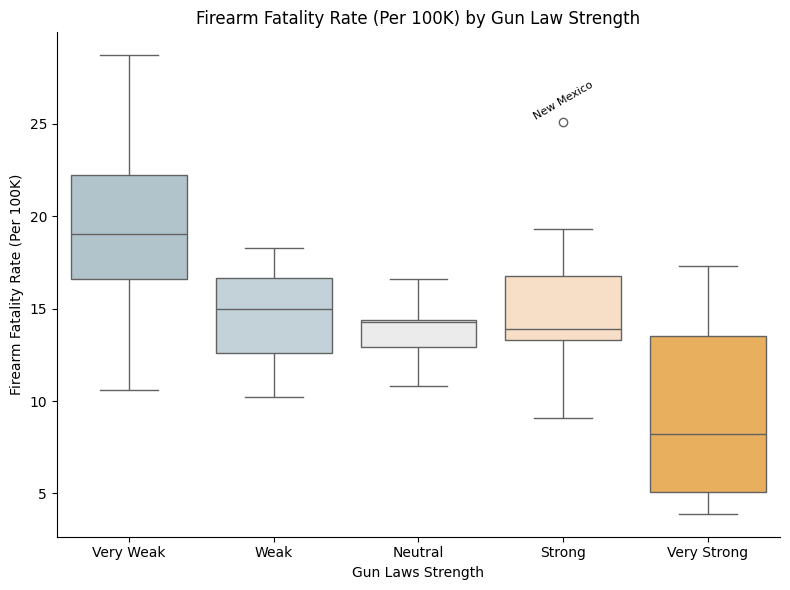

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

order = ["Very Weak", "Weak", "Neutral", "Strong", "Very Strong"]
palette = sns.color_palette(likert_colors, n_colors=len(order)) 
plt.figure(figsize=(8, 6))
ax = sns.boxplot(
    data=merged,
    x="gun_laws",
    y="rate",
    order=order,
    palette=palette
)
sns.despine()
plt.xlabel("Gun Laws Strength")
plt.ylabel("Firearm Fatality Rate (Per 100K)")
plt.title("Firearm Fatality Rate (Per 100K) by Gun Law Strength")
plt.xticks(rotation=0)

# --- Identify and label outliers ---
for i, level in enumerate(order):
    subset = merged[merged["gun_laws"] == level]
    q1 = subset["rate"].quantile(0.25)
    q3 = subset["rate"].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    # Filter outliers
    outliers = subset[(subset["rate"] < lower) | (subset["rate"] > upper)]

    # Label each outlier
    for _, row in outliers.iterrows():
        ax.text(
            x=i, 
            y=row["rate"], 
            s=row["state"],  # assumes you have a 'state' column
            ha="center", 
            va="bottom",
            fontsize=8,
            color="black",
            rotation=30
        )

plt.tight_layout()
plt.show()
